# Projet DATA732
## Text Clustering by Latent Dirichlet Allocation with TfidfVectorizer
Clusters of the articles description by the contents

## 0) Pre config

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import string, json

# from nltk.corpus import stopwords

from IPython.display import display
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

# from bokeh.plotting import figure, show
# from bokeh.models import Label
# from bokeh.io import output_notebook
# output_notebook()

%matplotlib inline

Loading BokehJS ...

## 1) Data
Data extraction from pre-generated df 

In [59]:
file_path = "../data/1eb80fb8b50.json"

segment_key = ["kws-l", "loc-l", "org-l", "per-l", "content-segmented"]
Years = ["2024"]

columns_to_use = ["loc-l", "org-l", "per-l"]
ignore_words = ["Telegram", "TikTok", "Sputnik Africa"]

display_graph = False
save_graph = True
name_graph_saved = "graph_0"

colors = ['#1f78b4',
            '#33a02c',
            '#e31a1c',
            '#ff7f00',
            '#6a3d9a']
    
# Get open data.
try:
    with open(file_path, "r") as json_file:
        data = json.load(json_file)
except FileNotFoundError:
    print(f"File not found: {file_path}")
except json.JSONDecodeError as e:
    print(f"JSON decoding error: {e}")
    
# Get the data from the json.
df = pd.DataFrame(columns=["year", "month", "day", "url", "title"] + segment_key)

for year in Years:
    for month in range(1, 13):
        for day in range(1, 32):
            num = 0
            while True:
                try:
                    data_tmp = data['data'][str(year)][str(month)][str(day)][num]
                    num += 1

                    base_data = {
                        "year": year,
                        "month": month,
                        "day": day,
                        "url": data_tmp.get("url", ""),
                        "title": data_tmp.get("title", "")
                    }

                    # Create a dictionary to hold the segment data
                    dict_tmp = {key: [] for key in segment_key}

                    # Extract segment data for each key
                    for key in segment_key:
                        if key in data_tmp:
                            for segment_data_tmp in data_tmp[key]:
                                for segment_data in segment_data_tmp:
                                    dict_tmp[key].append(segment_data)
                        else:
                            dict_tmp[key].append(None)

                    max_length = max([len(value) for value in dict_tmp.values()])

                    for key in dict_tmp.keys():
                        while len(dict_tmp[key]) < max_length:
                            dict_tmp[key].append(None)

                    for i in range(max_length):
                        new_data = base_data.copy()
                        for key in segment_key:
                            new_data[key] = dict_tmp[key][i]
                        df = pd.concat([df, pd.DataFrame([new_data])], ignore_index=True)

                except KeyError:
                    break
                except Exception as e:
                    break
df = df.explode("content-segmented", ignore_index=True)

df

,year,month,day,url,title,kws-l,loc-l,org-l,per-l,content-segmented
0,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[monopolize, african, expert, financial, syste...",[],[BRICS],[],"""They're monopolizing everything"": African exp..."
1,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[world, banking, multinational, company, monop...",[Musawenkosi Mdluli],[World BRICS South Africa],[Sputnik Africa],World banking and multinational companies are ...
2,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[world, banking, multinational, company, monop...",[],[],[],"""[...] World banking [...] and [...] multinati..."
3,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...",[control],[],[],[],Because now everything has been controlled by ...
4,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[multipolar, system, affect, change, financial...",[Mdluli],[],[],[...] So the multipolar system will also affec...
...,...,...,...,...,...,...,...,...,...,...
3318,2024,3,15,Sputnik Africa-14914,"🇰🇲🇷🇺 ""The process is more than transparent"": C...","[russian, presidential, election, number, adva...",[Comoro],[Independent National Electoral Commission],"[Ahmed Said Mdahoma, Sputnik Africa]",The Russian presidential election has a number...
3319,2024,3,15,Sputnik Africa-14914,"🇰🇲🇷🇺 ""The process is more than transparent"": C...","[note, maximum, security, ensure, calm, electo...",[],[Central Electoral Commission],[],"He also noted ""maximum"" security to ensure the..."
3320,2024,3,15,Sputnik Africa-14914,"🇰🇲🇷🇺 ""The process is more than transparent"": C...","[addition, mdahoma, emphasize, day, voting, pe...",[],[Mdahoma],[],"In addition, Mdahoma emphasized a 3-day voting..."
3321,2024,3,15,Sputnik Africa-14914,"🇰🇲🇷🇺 ""The process is more than transparent"": C...",[subscribe],[africa],[],[],Subscribe to @sputnik_africa


In [60]:
# # df = pd.read_json('./new_df/df_kws_article.json', orient='records')
# df = pd.read_json('./new_df/df_multiple_articles.json', orient='records')

In [61]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [62]:
numberArticles = df.shape[0]
print(f'Number of articles: {numberArticles}')

Number of articles: 3323


In [63]:
none_count = df['content-segmented'].isna().sum()
print(f"number None type in content-segmented: {none_count}")
print(f'Porcentage of None value in total: {100*none_count/df.shape[0]:.2f} %')

df = df.dropna(subset=['content-segmented'])

number None type in content-segmented: 0
Porcentage of None value in total: 0.00 %


### 1.1) Text Cleaning 

In [64]:
df['CleanedData']=df['content-segmented'].str.lower()

df['CleanedData'] = df['CleanedData'].str.replace('[{}]'.format(string.punctuation), '', regex=True)
df.head(5)

,year,month,day,url,title,kws-l,loc-l,org-l,per-l,content-segmented,date,CleanedData
0,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[monopolize, african, expert, financial, syste...",[],[BRICS],[],"""They're monopolizing everything"": African exp...",2024-02-29,theyre monopolizing everything african expert ...
1,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[world, banking, multinational, company, monop...",[Musawenkosi Mdluli],[World BRICS South Africa],[Sputnik Africa],World banking and multinational companies are ...,2024-02-29,world banking and multinational companies are ...
2,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[world, banking, multinational, company, monop...",[],[],[],"""[...] World banking [...] and [...] multinati...",2024-02-29,world banking and multinational companies ...
3,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...",[control],[],[],[],Because now everything has been controlled by ...,2024-02-29,because now everything has been controlled by ...
4,2024,2,29,Sputnik Africa-14278,"""They're monopolizing everything"": African exp...","[multipolar, system, affect, change, financial...",[Mdluli],[],[],[...] So the multipolar system will also affec...,2024-02-29,so the multipolar system will also affect and...


## 2) Vectorization 

In [65]:
list_suplementaire_stopwords = [
    "a", "à", "â", "abord", "afin", "ah", "ai", "aie", "ainsi", "allaient", "allo", "allô",
    "allons", "après", "assez", "attendu", "au", "aucun", "aucune", "aujourd", "aujourd'hui",
    "auquel", "aura", "auront", "aussi", "autre", "autres", "aux", "auxquelles", "auxquels",
    "avaient", "avais", "avait", "avant", "avec", "avoir", "ayant", "b", "bah", "beaucoup",
    "bien", "bigre", "boum", "bravo", "brrr", "c", "ça", "car", "ce", "ceci", "cela",
    "celle", "celle-ci", "celle-là", "celles", "celles-ci", "celles-là", "celui", "celui-ci",
    "celui-là", "cent", "cependant", "certain", "certaine", "certaines", "certains", "certes",
    "ces", "cet", "cette", "ceux", "ceux-ci", "ceux-là", "chacun", "chaque", "cher", "chère",
    "chères", "chers", "chez", "chiche", "chut", "ci", "cinq", "cinquantaine", "cinquante",
    "cinquantième", "cinquième", "clac", "clic", "combien", "comme", "comment", "compris",
    "concernant", "contre", "couic", "crac", "d", "da", "dans", "de", "debout", "dedans",
    "dehors", "delà", "depuis", "derrière", "des", "dès", "désormais", "desquelles", "desquels",
    "dessous", "dessus", "deux", "deuxième", "deuxièmement", "devant", "devers", "devra",
    "différent", "différente", "différentes", "différents", "dire", "divers", "diverse", "diverses",
    "dix", "dix-huit", "dixième", "dix-neuf", "dix-sept", "doit", "doivent", "donc", "dont",
    "douze", "douzième", "dring", "du", "duquel", "durant", "e", "effet", "eh", "elle",
    "elle-même", "elles", "elles-mêmes", "en", "encore", "entre", "envers", "environ", "es",
    "ès", "est", "et", "etant", "étaient", "étais", "était", "étant", "etc", "été", "etre",
    "être", "eu", "euh", "eux", "eux-mêmes", "excepté", "f", "façon", "fais", "faisaient",
    "faisant", "fait", "feront", "fi", "flac", "floc", "font", "g", "gens", "h", "ha",
    "hé", "hein", "hélas", "hem", "hep", "hi", "ho", "holà", "hop", "hormis", "hors",
    "hou", "houp", "hue", "hui", "huit", "huitième", "hum", "hurrah", "i", "il", "ils",
    "importe", "j", "je", "jusqu", "jusque", "k", "l", "la", "là", "laquelle", "las",
    "le", "lequel", "les", "lès", "lesquelles", "lesquels", "leur", "leurs", "longtemps",
    "lorsque", "lui", "lui-même", "m", "ma", "maint", "mais", "malgré", "me", "même",
    "mêmes", "merci", "mes", "mien", "mienne", "miennes", "miens", "mille", "mince", "moi",
    "moi-même", "moins", "mon", "moyennant", "n", "na", "ne", "néanmoins", "neuf", "neuvième",
    "ni", "nombreuses", "nombreux", "non", "nos", "notre", "nôtre", "nôtres", "nous",
    "nous-mêmes", "nul", "o", "o|", "ô", "oh", "ohé", "olé", "ollé", "on", "ont", "onze",
    "onzième", "ore", "ou", "où", "ouf", "ouias", "oust", "ouste", "outre", "p", "paf", "pan",
    "par", "parmi", "partant", "particulier", "particulière", "particulièrement", "pas", "passé",
    "pendant", "personne", "peu", "peut", "peuvent", "peux", "pff", "pfft", "pfut", "pif",
    "plein", "plouf", "plus", "plusieurs", "plutôt", "pouah", "pour", "pourquoi", "premier",
    "première", "premièrement", "près", "proche", "psitt", "puisque", "q", "qu", "quand", "quant",
    "quanta", "quant-à-soi", "quarante", "quatorze", "quatre", "quatre-vingt", "quatrième",
    "quatrièmement", "que", "quel", "quelconque", "quelle", "quelles", "quelque", "quelques",
    "quelquun", "quels", "qui", "quiconque", "quinze", "quoi", "quoique", "r", "revoici", "revoilà",
    "rien", "s", "sa", "sacrebleu", "sans", "sapristi", "sauf", "se", "seize", "selon",
    "sept", "septième", "sera", "seront", "ses", "si", "sien", "sienne", "siennes", "siens",
    "sinon", "six", "sixième", "soi", "soi-même", "soit", "soixante", "son", "sont", "sous",
    "stop", "suis", "suivant", "sur", "surtout", "t", "ta", "tac", "tant", "te", "té",
    "tel", "telle", "tellement", "telles", "tels", "tenant", "tes", "tic", "tien", "tienne",
    "tiennes", "tiens", "toc", "toi", "toi-même", "ton", "touchant", "toujours", "tous", "tout",
    "toute", "toutes", "treize", "trente", "très", "trois", "troisième", "troisièmement", "trop",
    "tsoin", "tsouin", "tu", "u", "un", "une", "unes", "uns", "v", "va", "vais", "vas",
    "vé", "vers", "via", "vif", "vifs", "vingt", "vivat", "vive", "vives", "vlan", "voici",
    "voilà", "vont", "vos", "votre", "vôtre", "vôtres", "vous", "vous-mêmes", "vu", "w", "x",
    "y", "z", "zut", "alors", "aucuns", "bon", "devrait", "dos", "droite", "début", "essai",
    "faites", "fois", "force", "haut", "ici", "juste", "maintenant", "mine", "mot", "nommés",
    "nouveaux", "parce", "parole", "personnes", "pièce", "plupart", "seulement", "soyez", "sujet",
    "tandis", "valeur", "voie", "voient", "état", "étions"] 

In [66]:
# listStopWords = stopwords.words('french') + stopwords.words('english') + list_suplementaire_stopwords + ['france', '2019', '2020', '2021']
listStopWords = list_suplementaire_stopwords + ['france', '2019', '2020', '2021']

In [67]:
reindexed_data = df['CleanedData']
reindexed_data.index = df['date']

In [68]:
tfidf_vectorizer = TfidfVectorizer(
    min_df =0.1,  
    stop_words=listStopWords
)

In [69]:
numberFeature = tfidf_vectorizer.fit_transform(reindexed_data).shape[1]
print(f"For {numberArticles} articles, each article have {numberFeature} features.")

For 3323 articles, each article have 17 features.


## 3) Clustering 

### 3.1) Preprocessing for clustering 

In [70]:
def get_top_n_words(n_top_words, tfidf_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a TfidfVectorizer object and text sample
    '''
    vectorized_headlines = tfidf_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0] for word in tfidf_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [72]:
# words, word_values = get_top_n_words(n_top_words=25,
#                                      tfidf_vectorizer=tfidf_vectorizer, 
#                                      text_data=reindexed_data)

# fig, ax = plt.subplots(figsize=(16,8))
# ax.bar(range(len(words)), word_values);
# ax.set_xticks(range(len(words)));
# ax.set_xticklabels(words, rotation='vertical');
# ax.set_title('Top words in headlines dataset (excluding stop words)');
# ax.set_xlabel('Word');
# ax.set_ylabel('Number of occurences');
# plt.show()

In [75]:
# tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [77]:
# tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

# word_counts = [] 
# pos_counts = {}

# for headline in tagged_headlines_df[u'tags']:
#     word_counts.append(len(headline))
#     for tag in headline:
#         if tag[1] in pos_counts:
#             pos_counts[tag[1]] += 1
#         else:
#             pos_counts[tag[1]] = 1
            
# print('Total number of words: ', np.sum(word_counts))
# print('Mean number of words per artcle: ', np.mean(word_counts))

In [78]:
print('Article before vectorization: {}'.format(reindexed_data[123]))

term_matrix = tfidf_vectorizer.fit_transform(reindexed_data.tolist())

print('Headline after vectorization: \n{}'.format(term_matrix[123]))

Article before vectorization: 🔹 yevgenia gutsul also stressed the need to improve transportation accessibility so that gagauzian residents can have the opportunity to travel to russia
Headline after vectorization: 
  (0, 12)	0.4562711261406025
  (0, 14)	0.7810989523747021
  (0, 11)	0.42626410363708694


C:\Users\carlo\AppData\Local\Temp\ipykernel_73004\3527170392.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Article before vectorization: {}'.format(reindexed_data[123]))


In [79]:
n_topics = 7

### 3.3) Latent Dirichilet Allocation

In [80]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

def get_top_n_words_LDA(n, keys, document_term_matrix, tfidf_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = np.zeros((1, document_term_matrix.shape[1]))
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i].toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:], 0)
        top_word_indices.append(top_n_word_indices)
    
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1, document_term_matrix.shape[1]))
            temp_word_vector[:, index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word)
        top_words.append(" ".join(topic_words))
    
    return top_words

def get_mean_topic_vectors(keys, two_dim_vectors):
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [81]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [82]:
print("Shape of Document-Term Matrix:", term_matrix.shape)


Shape of Document-Term Matrix: (3323, 17)


In [83]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='batch', random_state=0, verbose=0)

lda_topic_matrix = lda_model.fit_transform(term_matrix)

In [84]:

from collections import Counter

your_list = get_keys(lda_topic_matrix)

element_counts = Counter(your_list)

for element, count in element_counts.items():
    print(f"{element}: {count} times")


4: 129 times
5: 1152 times
0: 670 times
6: 519 times
2: 404 times
1: 412 times
3: 37 times


In [85]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

Text(0, 0.5, 'Number of headlines')

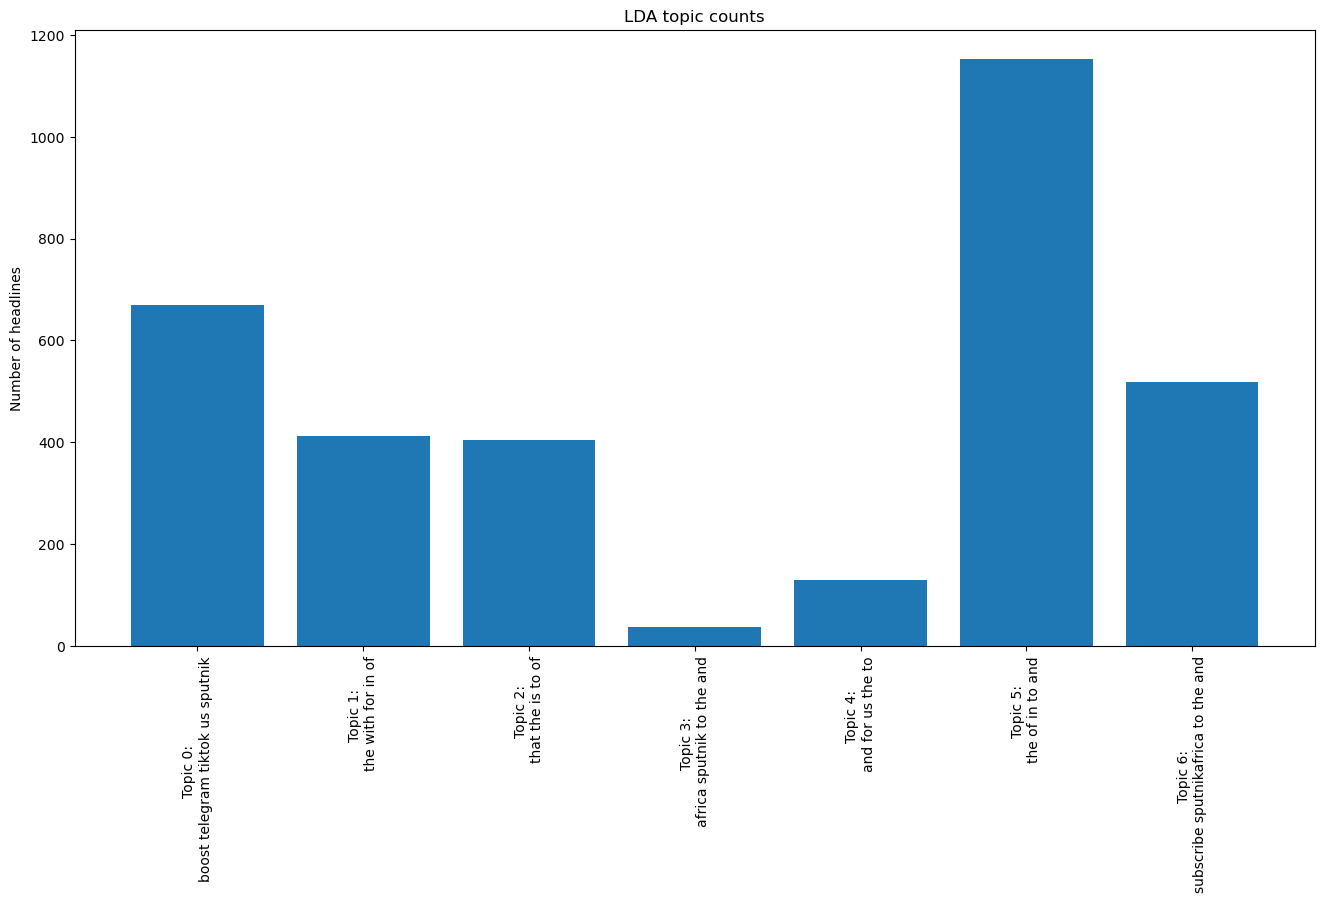

In [86]:
top_3_words = get_top_n_words_LDA(5, lda_keys, term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(lda_categories, lda_counts)
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('LDA topic counts')
ax.set_ylabel('Number of headlines')

In [87]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate='auto', 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

c:\Users\carlo\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3323 samples in 0.003s...
[t-SNE] Computed neighbors for 3323 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3323
[t-SNE] Computed conditional probabilities for sample 2000 / 3323
[t-SNE] Computed conditional probabilities for sample 3000 / 3323
[t-SNE] Computed conditional probabilities for sample 3323 / 3323
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.675060
[t-SNE] KL divergence after 2000 iterations: -0.154867


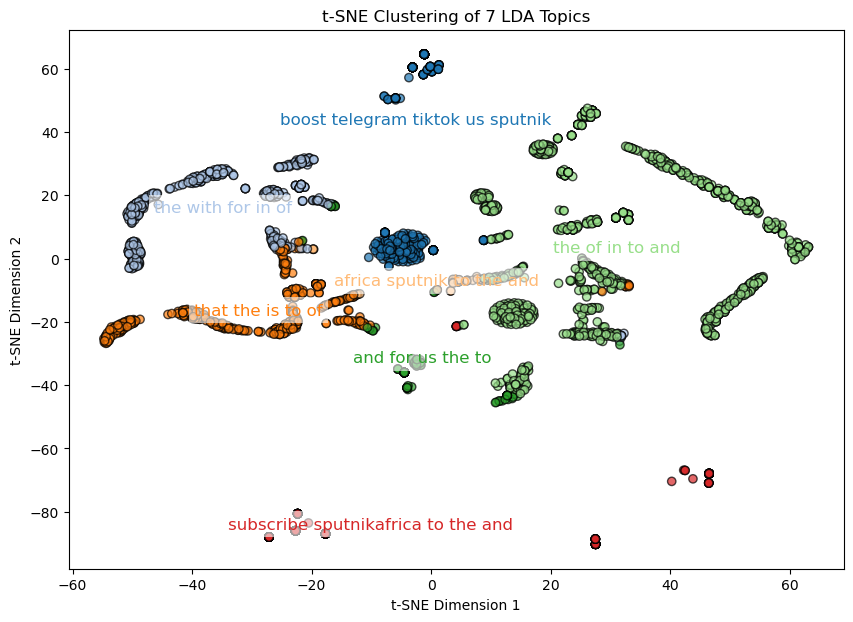

In [96]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_lda_vectors[:, 0], tsne_lda_vectors[:, 1], 
                        c=[colormap[key] for key in lda_keys], alpha=0.7, edgecolors='k')

# Adding labels for each topic's mean position
for t in range(n_topics):
    plt.text(lda_mean_topic_vectors[t][0], lda_mean_topic_vectors[t][1], 
                top_3_words_lda[t], fontsize=12, color=colormap[t], ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title(f"t-SNE Clustering of {n_topics} LDA Topics")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

## 4) EDA

In [97]:
df['cluster'] = lda_keys
df['vector1'] = tsne_lda_vectors[:, 0]
df['vector2'] = tsne_lda_vectors[:, 1]

In [99]:
top_3_words_lda = get_top_n_words_LDA(30, lda_keys, term_matrix, tfidf_vectorizer)

dict_clucter_30_words = {i: top_3_words_lda[i] for i in range(len(top_3_words_lda))}
dict_clucter_30_words

{0: 'boost telegram tiktok us sputnik africa in and the is for with of subscribe that to sputnikafrica',
 1: 'the with for in of and to is that africa sputnik us telegram subscribe boost tiktok sputnikafrica',
 2: 'that the is to of and in with africa sputnik us for telegram subscribe boost tiktok sputnikafrica',
 3: 'africa sputnik to the and in is of with us for that subscribe telegram boost tiktok sputnikafrica',
 4: 'and for us the to with that in is of africa sputnik subscribe telegram boost tiktok sputnikafrica',
 5: 'the of in to and that for africa is sputnik us with telegram boost subscribe tiktok sputnikafrica',
 6: 'subscribe sputnikafrica to the and africa telegram that us sputnik of is in for boost tiktok with'}

In [98]:
dict_clucter_title = {
    0: 'Crime and Justice',
    1: 'Public Health and COVID-19',
    2: 'Economics and Finance',
    3: 'International Relations and Military',
    4: 'Government and Politics',
    5: 'Military and War',
    6: 'Leadership and Politics'
}

In [32]:
df['cluster_30_words'] = df['cluster'].map(dict_clucter_30_words)
df['cluster_title'] = df['cluster'].map(dict_clucter_title)

In [ ]:
fig = px.scatter(df, x='vector1', y='vector2', color='cluster_title', hover_data=['title', 'description', 'domain'])
fig.update_layout(title='Scatter Plot with Cluster Colors and Keys')
fig.update_xaxes(title='Vector 1')
fig.update_yaxes(title='Vector 2')

fig.write_html("./html_images_cluster/Scatter_cluster.html")

fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['year', 'month', 'day', 'url', 'title', 'kws-l', 'loc-l', 'org-l', 'per-l', 'content-segmented', 'date', 'CleanedData'] but received: vector1

## 5) Save df

In [ ]:
df_final_draft = df[['date', 'url', 'domain', 'title', 'cluster', 'vector1', 'vector2', 'cluster_30_words', 'cluster_title']]
df_final_draft.head(5)

,date,url,domain,title,cluster,vector1,vector2,cluster_30_words,cluster_title
0,2019-01-02,https://french.presstv.ir/Detail/2019/01/03/58...,french.presstv.ir,Des terroristes de l'Armée syrienne libre envo...,2,-27.939808,8.679305,algérie pays militaire armée maroc israël algé...,Algeria-Morocco Conflict Dynamics
1,2019-01-03,https://french.presstv.ir/Detail/2019/01/04/58...,french.presstv.ir,Zoom Afrique du 4 janvier 2019,3,9.868510,-13.643680,pays mali armée président afrique forces barkh...,Mali Crisis and Government Response
2,2019-01-03,https://french.presstv.ir/Detail/2019/01/04/58...,french.presstv.ir,Les terroristes veulent déstabiliser l’Algérie,2,-27.256174,8.257619,algérie pays militaire armée maroc israël algé...,Algeria-Morocco Conflict Dynamics
3,2019-01-04,https://french.presstv.ir/Detail/2019/01/05/58...,french.presstv.ir,Zoom Afrique du 5 janvier 2019,0,2.600644,-11.895773,pays afrique côte président mali ivoire faire ...,International Relations and Security
4,2019-01-05,https://french.presstv.ir/Detail/2019/01/06/58...,french.presstv.ir,Zoom Afrique du 6 janvier 2019,1,-7.249902,-10.655392,pays afrique mali terroristes sahel président ...,Military Presence in Sahel Region


In [ ]:
df_final_draft['domain'].unique()

array(['french.presstv.ir'], dtype=object)

In [ ]:
# Save the DataFrame to a JSON file

# df_final_draft.to_json('./results/df_final_LDA-countVect.csv')

In [ ]:
# df_final_draft.to_csv('./df_final_LDA-CountVect.csv', index=False)
